# Build and Train model on limited dataset

In [1]:
import numpy as np
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from keras.models import Model
from keras.layers import Input
from keras import backend as K

from deeplabv3plus import build_deeplab
from PatchGenerator import patch_generator


import json

Using TensorFlow backend.


In [2]:
with open('all_patch_list.json', 'rb') as f:
    all_patch_list = json.load(f)['list']
    
with open('detections_patch_list.json', 'rb') as f:
    detections_patch_list = json.load(f)['list']

In [3]:
train_all_list, test_all_list = train_test_split(all_patch_list, test_size=0.1)
train_true_list, test_true_list = train_test_split(detections_patch_list, test_size=0.1)

In [4]:
#len(train_all_list), len(test_all_list), len(train_true_list), len(test_true_list)

In [26]:
dims = (350,350)
input_patch = Input(shape=(dims[0],dims[1],3,))
logits = build_deeplab(input_patch, num_classes=1)

model = Model(input_patch, logits)

len(atrous_rates): 3


### Get subset to test by overfitting:


In [27]:
sub_train_all_list = train_all_list[:256]
sub_train_true_list = train_true_list[:50]
len(sub_train_all_list), len(sub_train_true_list)

(256, 50)

In [51]:
batch_size = 24
generator = patch_generator('/home/mak/PathAI/slides/', sub_train_all_list, sub_train_true_list, batch_size=batch_size, dims=dims)

In [52]:
model.compile(optimizer='adam', loss='mse')

In [53]:
model.fit_generator(generator, steps_per_epoch=(256/(batch_size*0.5)), epochs=10)

Epoch 1/10
22/21 [==============================] - 37s 2s/step - loss: 0.1271
Epoch 2/10
22/21 [==============================] - 14s 623ms/step - loss: 0.0974
Epoch 3/10
22/21 [==============================] - 13s 597ms/step - loss: 0.0752
Epoch 4/10
22/21 [==============================] - 19s 847ms/step - loss: 0.0680
Epoch 5/10
22/21 [==============================] - 13s 576ms/step - loss: 0.0625
Epoch 6/10
22/21 [==============================] - 13s 575ms/step - loss: 0.0513
Epoch 7/10
22/21 [==============================] - 13s 576ms/step - loss: 0.0701
Epoch 8/10
22/21 [==============================] - 13s 577ms/step - loss: 0.0671
Epoch 9/10
22/21 [==============================] - 13s 578ms/step - loss: 0.0678
Epoch 10/10
22/21 [==============================] - 13s 577ms/step - loss: 0.0587


In [73]:
import matplotlib.pyplot as plt
from PIL import Image
from utils import getWSI, getRegionFromSlide, getLabel

In [119]:
level=1
test_patch_item = sub_train_all_list[np.random.randint(0, len(sub_train_true_list))]
test_patch = getRegionFromSlide(getWSI('/home/mak/PathAI/slides/'+test_patch_item[0]), 
                                level=level, 
                                start_coord=test_patch_item[1], dims=dims) 

In [120]:
prediction = model.predict(np.expand_dims(test_patch,0))

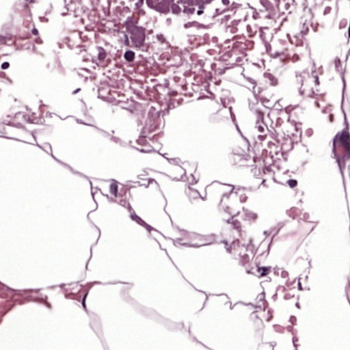

In [121]:
Image.fromarray(test_patch)

In [122]:
test_prediction = (prediction[0]*255).astype(np.int8)
test_prediction = np.dstack((test_prediction,test_prediction,test_prediction))
test_prediction.shape, test_prediction.dtype

((350, 350, 3), dtype('int8'))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


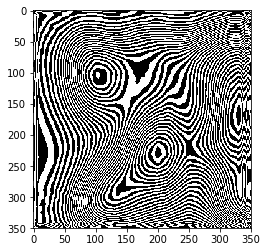

In [123]:
plt.imshow(test_prediction)

In [124]:
np.max(test_prediction), np.min(test_prediction)

(127, -128)

In [125]:
test_truth = getLabel('/home/mak/PathAI/slides/'+test_patch_item[0], 
                      level=level, coords=test_patch_item[1], 
                      dims=dims) #* 255
#test_truth = test_truth.astype(np.int8)
test_truth = np.dstack((test_truth,test_truth,test_truth))

test_truth.shape, test_truth.dtype

((350, 350, 3), dtype('float64'))

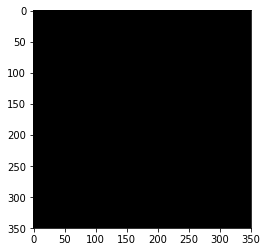

In [126]:
plt.imshow(test_truth)

In [104]:
test_patch_item

['patient_051_node_2.tif', [81216, 74688]]

In [11]:
'''
Max working config:
256x256 image - 45 batch_size
512x512 image - 8 batch_size
350x350 image - 24 batch_size
'''

'\nMax working config:\n256x256 image - 45 batch_size\n512x512 image - 8 batch_size\n'

In [7]:
def model_size(batch_size, model):
    shape_mem = 0

    for layer in model.layers:
        unit_count = 1
        for d in layer.output_shape:
            if d == None:
                continue
            unit_count *=d
        shape_mem += unit_count
    var_count = 0
    for w in model.weights:
        var_count += K.count_params(w)
    
    number_size = 4.0
    if K.floatx() == 'float16':
         number_size = 2.0
    if K.floatx() == 'float64':
         number_size = 8.0
    
    total_mem = number_size * (batch_size*shape_mem*2 + var_count)
    
    total_mem = total_mem / (1024**3)
    
    return total_mem


In [32]:
model_size(24, model)

11.449053537100554

In [26]:
K.count_params(w)

864